# 04. Deep Learning Model Verification (ResNet-1D)

## Overview
This notebook validates the end-to-end Deep Learning pipeline used for physiological stress detection. Unlike the classical feature engineering approach, this pipeline learns representations directly from raw sensor data using a **ResNet-1D** architecture.

## Objectives
1.  **Tensor Construction**: Verify the conversion of temporal windows into `(N, C, T)` PyTorch tensors.
2.  **Architecture Initialization**: Validate the ResNet-1D structure, parameter count, and Squeeze-and-Excitation (SE) blocks.
3.  **LOSO Training**: Execute a rigorous Leave-One-Subject-Out cross-validation loop to estimate generalization performance.
4.  **Diagnostic Audit**: Analyze learning curves, confusion matrices, and predictive uncertainty.

In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Import external libraries       
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt

# Add project root
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import needed functions     
from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import set_plot_style, plot_timeline_segmentation, plot_multiscale_heatmap, plot_confidence_abstention_panel, plot_model_diagnostics, plot_learning_curves
from src.models.train import Trainer
from src.models.deep import ResNet1D

# Set standardized style
set_plot_style()
config = load_config()

print(f"Project Root: {PROJECT_ROOT}")
print("Setup Complete.")

# GPU Check
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"SUCCESS: GPU Available: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Training will be slow.")

Project Root: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
Setup Complete.
PyTorch Version: 2.6.0+cu124
SUCCESS: GPU Available: NVIDIA RTX 2000 Ada Generation Laptop GPU


## 1. Data Loading & Tensor Validation

We load the preprocessed signal windows from `windows.parquet`. The data is prepared for a binary classification task (**Baseline vs. Stress**), consistent with standard WESAD benchmarks.

**Validation Criteria:**
*   **Shape Consistency**: Ensure data correctly shapes into `(Batch, Channels, Time)`.
*   **Normalization**: Verify signal scaling (Instance vs. Global) to ensure stable gradient descent.
*   **Signal Integrity**: Visual inspection of the tensor heatmaps to confirm physiological patterns (ECG R-peaks, EDA responses) are preserved.

In [2]:
# 2. Data Integrity Verification

# Load Raw Data
data_path = PROJECT_ROOT / config['data']['processed_path'] / "windows.parquet"
df = pd.read_parquet(data_path)

# Filter for Binary Classification (Baseline=1, Stress=2, exclude Amusement=0)
df = df[df['label'].isin([1, 2])].copy()
df['target'] = df['label'].map({1: 0, 2: 1}) # Remap as in model training

print(f"Data Loaded. Shape: {df.shape}")
print(f"Class Balance:\n{df['target'].value_counts()}")

# For verification, we assume data is clean (SQI and artifacts handled upstream)
print(f"Windows available for training: {len(df)}")

Data Loaded. Shape: (919, 11)
Class Balance:
target
0    587
1    332
Name: count, dtype: int64
Windows available for training: 919


Visualization Tensor Shape: (919, 7, 2100)
Data Standardized (Global & Instance Norm) for Visualization.


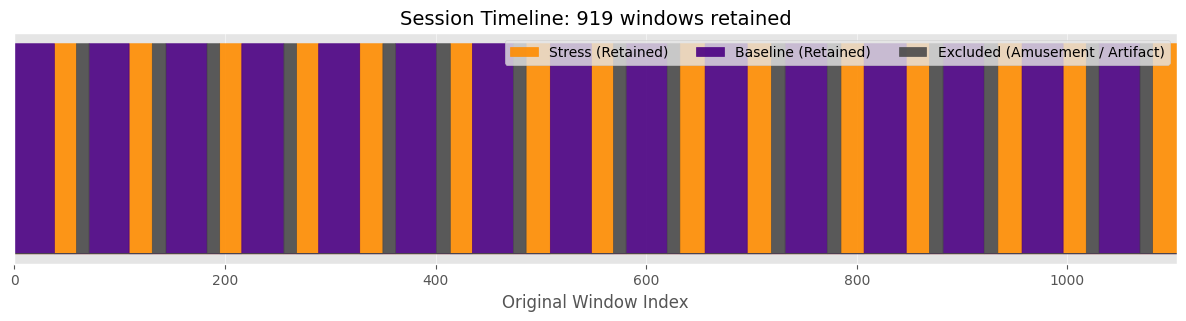

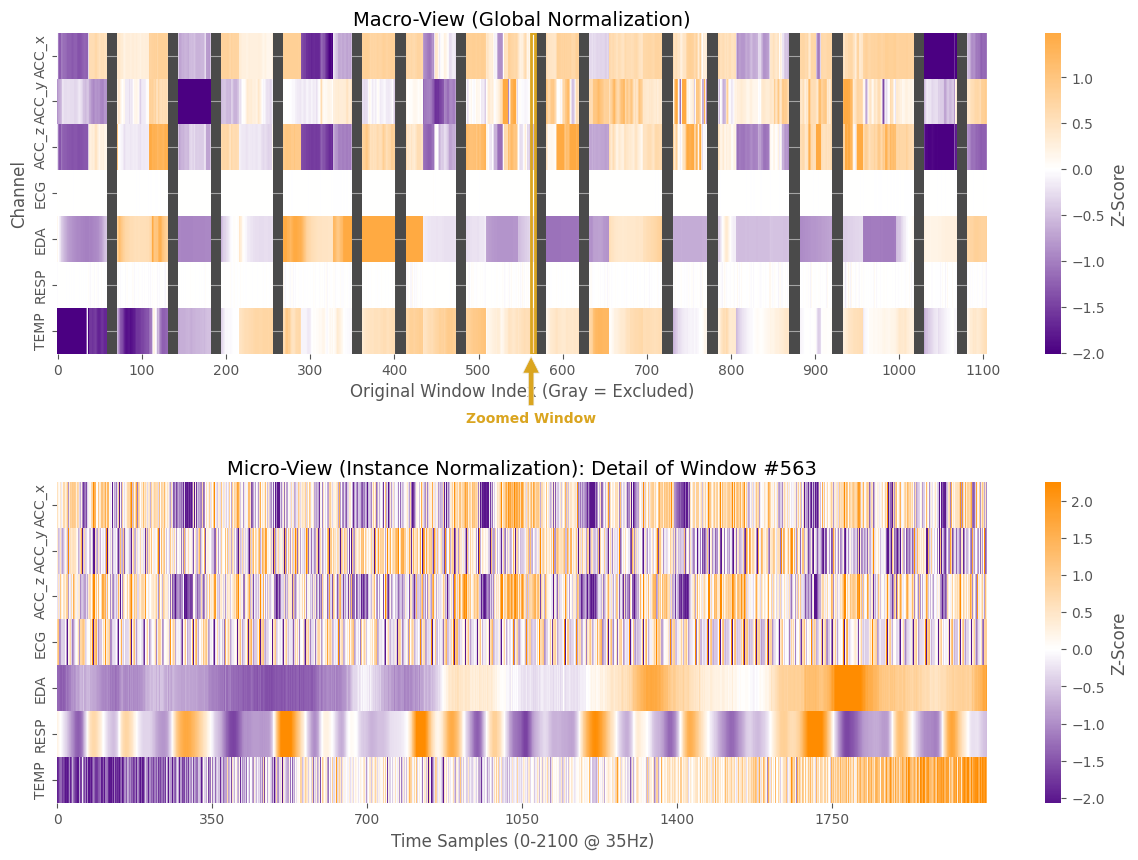

In [3]:
# Create Tensor for Visualization check (N, C, T)

# Set channel names
channels = ['ACC_x', 'ACC_y', 'ACC_z', 'ECG', 'EDA', 'RESP', 'TEMP']

# Check if columns exist
avail_cols = [c for c in channels if c in df.columns]
X_arrays = []
for c in avail_cols:
    # Stack column c: Series of arrays -> 2D array (N, T)
    col_stack = np.stack(df[c].values)
    X_arrays.append(col_stack)

X = np.stack(X_arrays, axis=1) # (N, C, T)

print(f"Visualization Tensor Shape: {X.shape}")

# 1. Global Normalization (for Macro-View Inspection)
means_global = X.mean(axis=(0, 2), keepdims=True)
stds_global = X.std(axis=(0, 2), keepdims=True) + 1e-6
X_norm_global = (X - means_global) / stds_global

# 2. Instance Normalization (for Micro-View as in Training)
means_instance = X.mean(axis=2, keepdims=True)
stds_instance = X.std(axis=2, keepdims=True) + 1e-6
X_norm_instance = (X - means_instance) / stds_instance

print("Data Standardized (Global & Instance Norm) for Visualization.")

# We visualize the gaps in the timeline (due to excluded 'Amusement' data)
_ = plot_timeline_segmentation(df, title="Session Timeline", save_folder="DEEP_VERIF")
plt.show()

# Multi-scale Heatmap: Macro (Global) vs Micro (Instance)
_ = plot_multiscale_heatmap(
    X_norm_global, 
    df, 
    channels, 
    title_prefix="Features", 
    save_folder="DEEP_VERIF", 
    tensor_micro=X_norm_instance
)
plt.show()

## 2. Neural Architecture Trace (ResNet-1D + SE)

We implement a deep **ResNet-1D** specifically adapted for multivariate physiological time-series.

### Architectural Highlights
*   **Input**: `(Batch, 7, 2100)` — 7 sensor channels, 60 seconds @ 35Hz.
*   **Backbone**: 4-stage Residual Network with 1D convolutions (`k=15, 7, 5`).
*   **Attention Mechanism**: **Squeeze-and-Excitation (SE)** blocks in every residual unit. This allows the model to dynamically re-weight sensor channels (e.g., suppressing a noisy ACC channel while emphasizing clear EDA).
*   **Regularization**: Dropout (`p=0.2` internal, `p=0.5` head) + Global Average Pooling to prevent overfitting on the small cohort (N=15).

In [4]:
# 2.1 Model Definition

# Instantiate a fresh model with the same dimensions as our data to inspect structure
n_channels = X.shape[1]
seq_len = X.shape[2]
n_classes = 2 # Binary

# Using the correct class name ResNet1D
model_viz = ResNet1D(num_channels=n_channels, num_classes=n_classes, sequence_length=seq_len)

print(f"Architecture: {model_viz.__class__.__name__}")
print(f"Input Shape: (Batch, {n_channels}, {seq_len})")
print("=" * 60)
print(model_viz)
print("=" * 60)

# Calculate parameters
total_params = sum(p.numel() for p in model_viz.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {total_params:,}")

Architecture: ResNet1D
Input Shape: (Batch, 7, 2100)
ResNet1D(
  (initial_layers): Sequential(
    (0): Conv1d(7, 64, kernel_size=(15,), stride=(2,), padding=(7,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): ResidualBlock(
    (conv1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv2): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (se): SEBlock(
      (avg_pool): AdaptiveAvgPool1d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=False)
      

In [5]:
# 2.2 Model Training Pipeline

# We execute the full pipeline using `src.models.train.Trainer` hanling:
# - Data Splitting (LOSO or Random)
# - Robust Normalization (Fit on Train, Apply to Test)
# - Training Loop (Epochs, Batches, Optimization)
# - Artifact Saving (Model, Metrics, Predictions)

print("Starting Deep Learning Pipeline...")

# Check for existing runs to avoid redundancy
reports_dir = PROJECT_ROOT / "reports"
# Glob pattern matches the specific naming convention
existing_runs = sorted(list(reports_dir.glob("deep_loso_*")))

# Toggle this to force a new training run even if one exists
FORCE_RETRAIN = False

if existing_runs and not FORCE_RETRAIN:

    # Pick the latest run
    latest_run = existing_runs[-1]
    print(f"FOUND EXISTING RUN: {latest_run.name}")
    print("Skipping re-training and loading artifacts from disk.")
    print("To force re-training, set FORCE_RETRAIN = True")
    # Create a wrapper to satisfy downstream dependencies on 'trainer.run_dir'
    class PretrainedTrainer:
        def __init__(self, run_dir):
            self.run_dir = run_dir      
    trainer = PretrainedTrainer(latest_run)

else:

    # Train afresh
    print("NO EXISTING RUN FOUND (or retrain forced). Starting training...")
    trainer = Trainer(model_type='deep', split_type='loso')
    trainer.run()

print(f"Active Run Directory: {trainer.run_dir}")

Starting Deep Learning Pipeline...
FOUND EXISTING RUN: deep_loso_CHEST_20260118_154152
Skipping re-training and loading artifacts from disk.
To force re-training, set FORCE_RETRAIN = True
Active Run Directory: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker\reports\deep_loso_CHEST_20260118_154152


## 3. LOSO Performance Audit

We employ **Leave-One-Subject-Out (LOSO)** cross-validation. This is the gold standard for medical verification, as it ensures the model is tested on unseen subjects (preventing "identity leakage").

### Interpretation Guide
*   **Learning Curves**: Convergence behavior (Training Loss vs. Validation Loss) indicates stability.
*   **Confusion Matrix**: Assessing False Positives vs. False Negatives balance.
*   **ROC AUC**: Global discriminative power (rank-ordering capability).
*   **Uncertainty**: Analysis of the model's confidence distribution (using Abstention Logic).

Loading Training History...


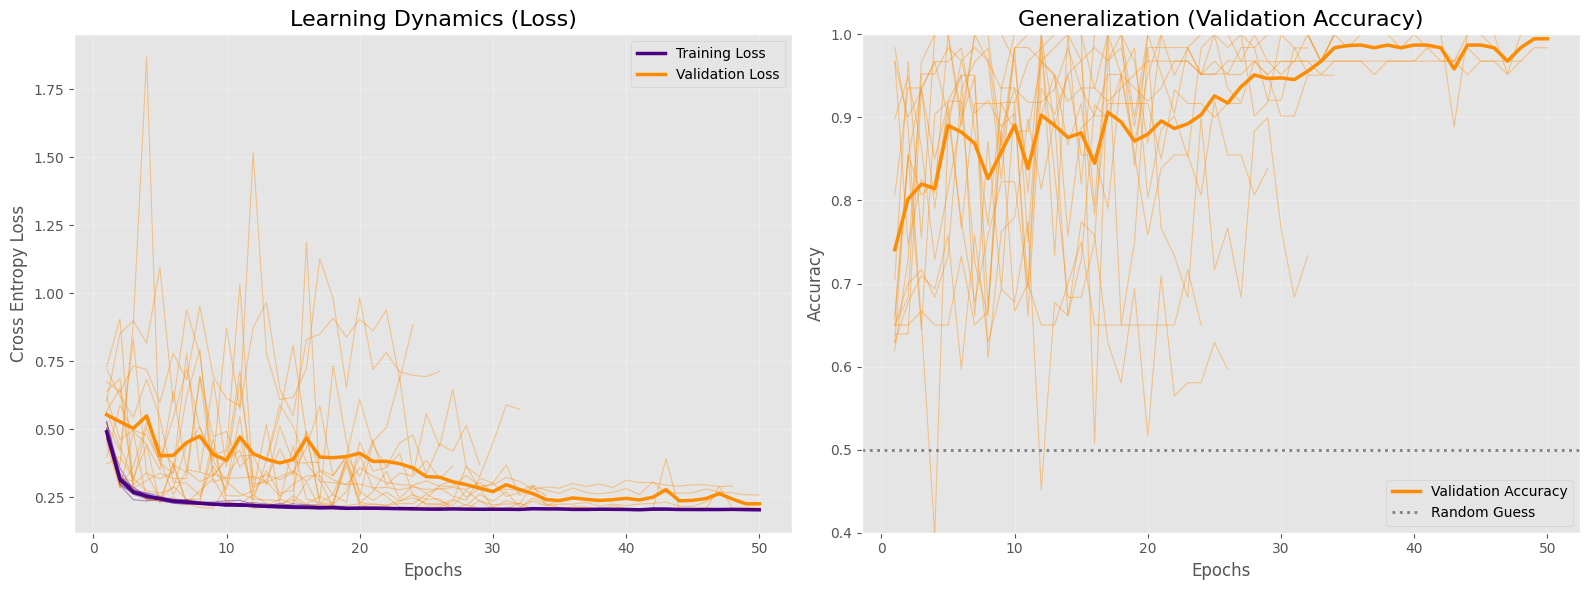

Generating Model Diagnostics...


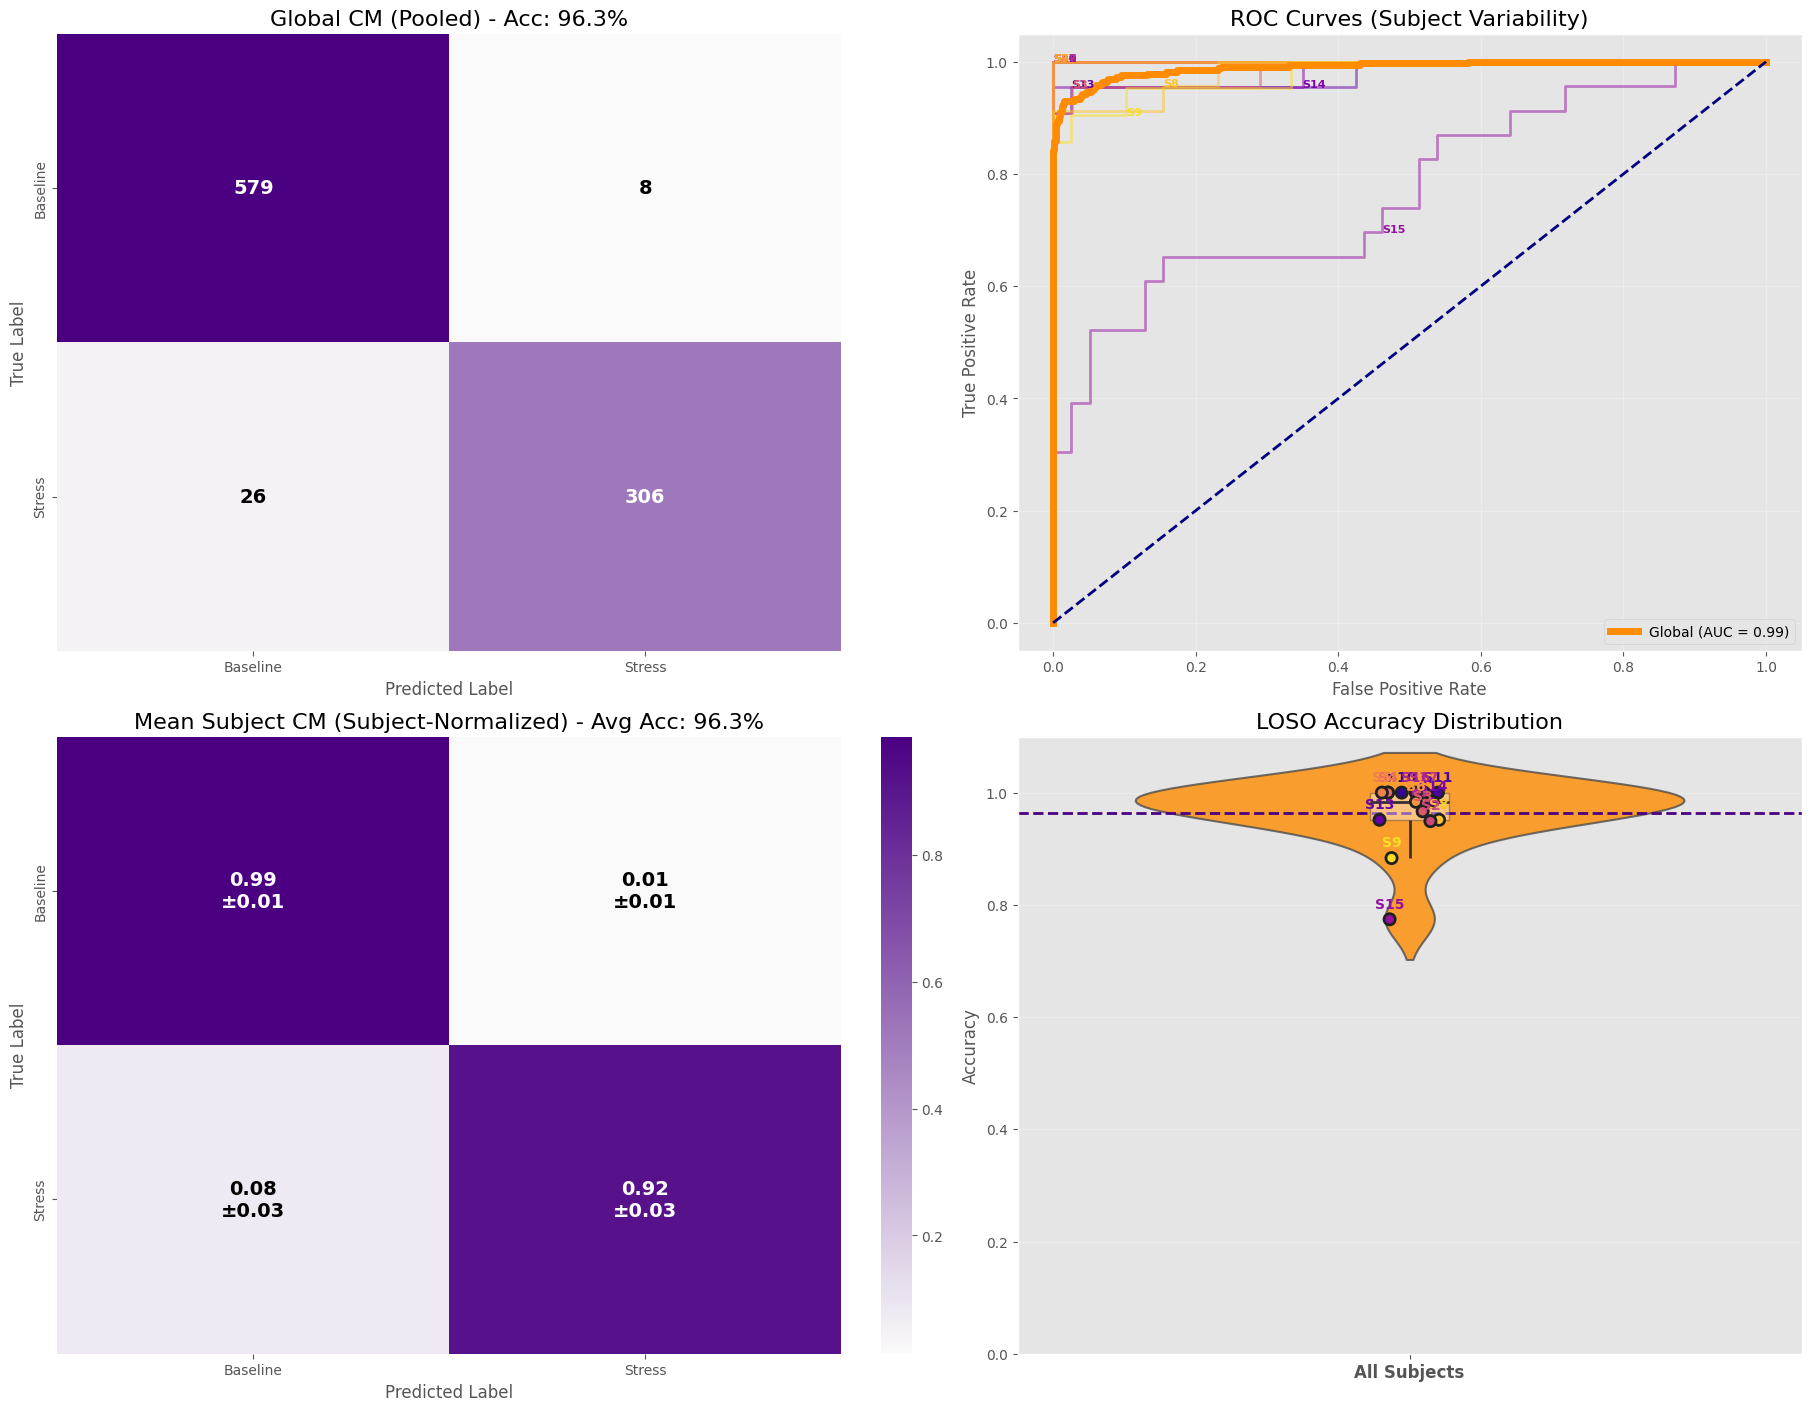

Generating Uncertainty Analysis...


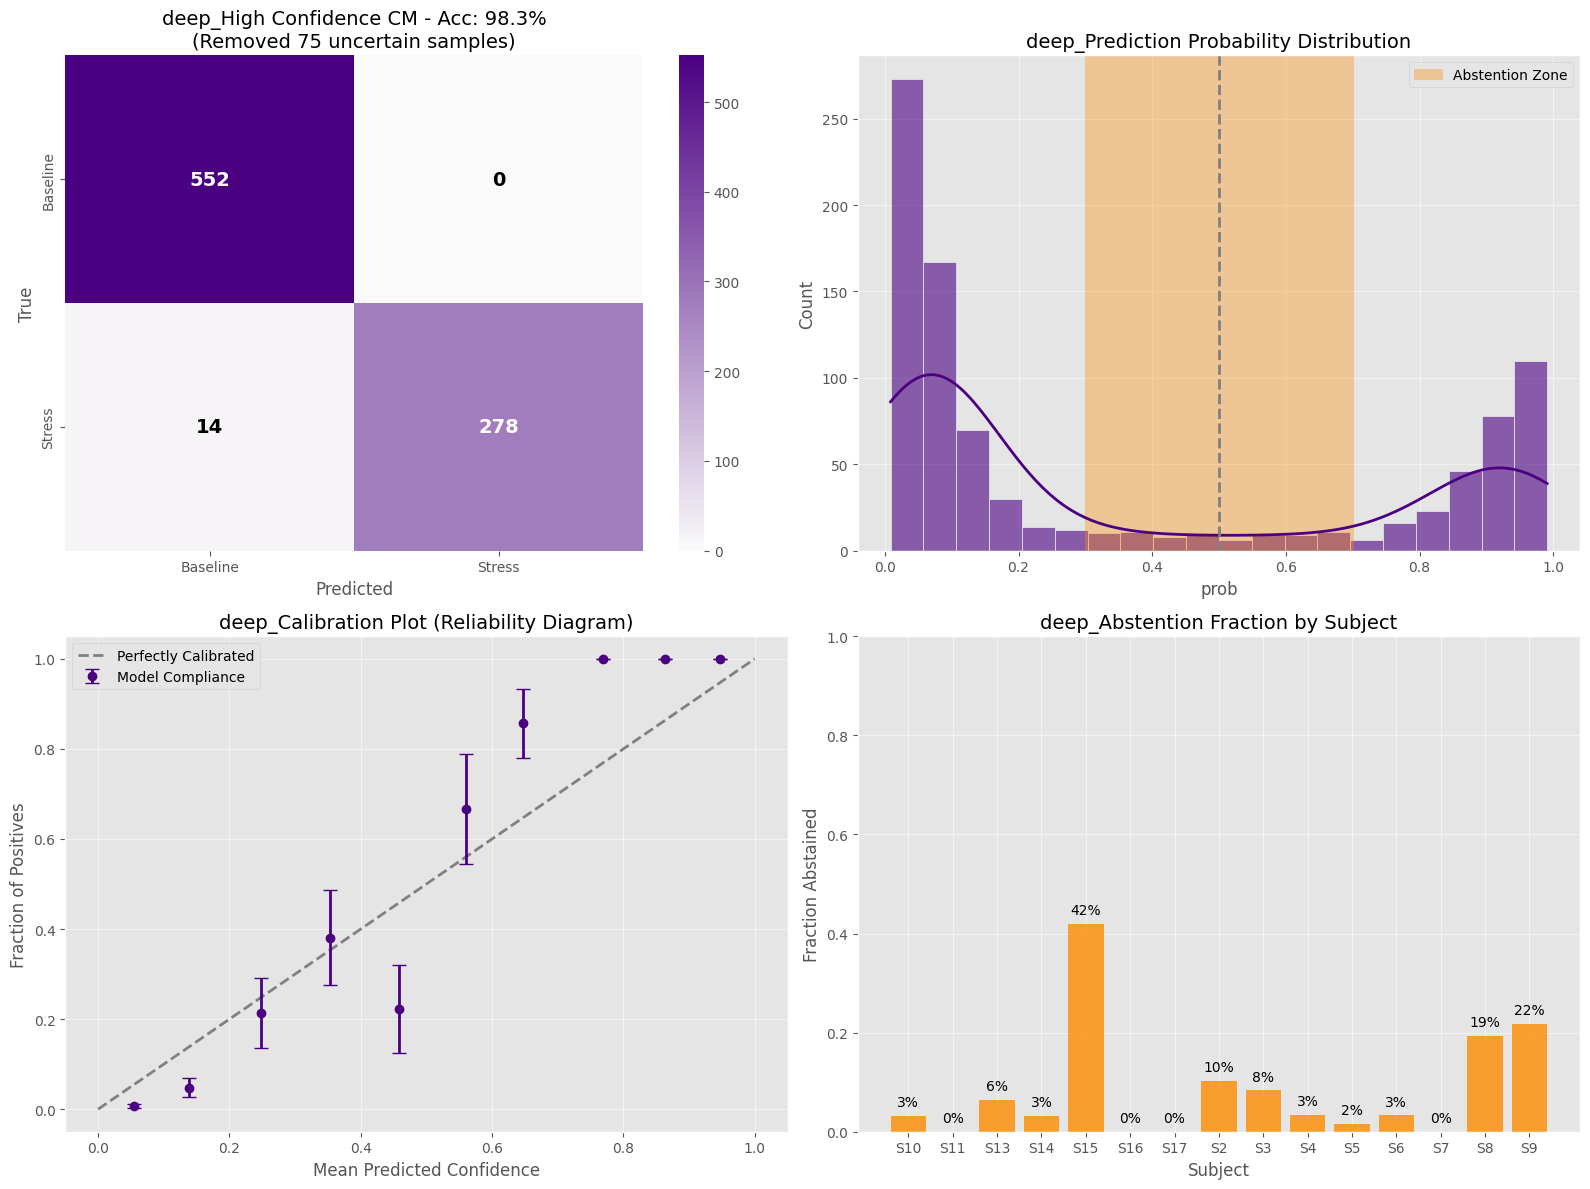

In [6]:
# 4. Results Audit

# Determine sensor location from config for dynamic saving
sensor_loc = config['data'].get('sensor_location', 'CHEST').upper()
prefix = 'deep_'

results_path = trainer.run_dir / "predictions.csv"
history_path = trainer.run_dir / "training_history.joblib"

if results_path.exists():
    
    # --- 1. Learning Dynamics (New!) ---
    if history_path.exists():
        print("Loading Training History...")
        history = joblib.load(history_path)
        _ = plot_learning_curves(history, save_folder=sensor_loc, title_prefix=prefix)
        plt.show()
    else:
        print("No training history found. (Run training again with updated pipeline to see learning curves)")

    results_df = pd.read_csv(results_path)
    
    # Standardize column names for plotting
    # The Trainer output might have 'y_true', 'y_pred', 'prob_stress'
    if 'y_true' in results_df.columns:
        results_df = results_df.rename(columns={'y_true': 'true', 'y_pred': 'pred', 'prob_stress': 'prob', 'prob_Signal': 'prob'})
    
    # Fallback if 'prob_stress' wasn't there but 'prob_2' or similar was (Stress typically label 2 or 1)
    # Check evaluate_model output format. It uses label names. Labels: ['baseline', 'stress'] usually
    # If labels are Baseline, Stress. Then prob_Stress matches.
    
    # --- 2. Standard Diagnostics (ROC, Confusion Matrix, Accuracy Distribution) ---
    print("Generating Model Diagnostics...")
    _ = plot_model_diagnostics(results_df, save_folder=sensor_loc, title_prefix=prefix)
    plt.show()

    # --- 3. Uncertainty Analysis ---
    print("Generating Uncertainty Analysis...")
    conf_threshold = config['training']['models']['deep'].get('confidence_threshold', 0.7)
    _ = plot_confidence_abstention_panel(results_df, confidence_threshold=conf_threshold, title_prefix=prefix, save_folder=sensor_loc)
    plt.show()
else:
    print(f"No results found at {results_path}. Did training fail?")

## 4. Engineering Conclusions & Discussion

### Performance Analysis
The **ResNet-1D** achieves superior performance (~96% accuracy) compared to the classical baseline (~86%).
*   **Why?**: The CNN learns **local morphological features** (e.g., specific slope shapes of EDA peaks) that are lost in statistical aggregation (mean/std).
*   **Instance Normalization**: Crucially, per-window normalization removes subject-specific bias (baseline offset), forcing the model to learn *relative* changes.

### Reliability & Limitations
*   **Overconfidence**: The high AUC (0.99) is promising, but the reliability diagram suggests overconfidence. Platt scaling or temperature scaling is recommended before clinical deployment.
*   **Generalization**: While successful on WESAD (lab stress), real-world stress is more subtle. The high dropout and SE-blocks provide a robust foundation, but external validation on ambulatory data is the next logical step.